# 사용한 라이브러리

In [1]:
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
import tensorflow as tf

# NN

In [2]:
class NN(tf.keras.Model):
    def __init__(self, action_size):
        super(NN, self).__init__()
        self.fc1 = Dense(24, activation = 'relu')
        self.fc2 = Dense(24, activation = 'relu')
        self.fc_out = Dense(action_size, kernel_initializer = RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q

# DQN

In [3]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.001
        self.batch_size = 64
        self.train_start = 1000

        self.memory = deque(maxlen = 2000)

        self.model = NN(self.action_size)
        self.target_model = NN(self.action_size)
        self.optimizer = Adam(learning_rate = self.learning_rate)

        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q = self.model(state) # 리스트 형태로 반환됨
            return np.argmax(q[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        mini_batch = random.sample(self.memory, self.batch_size)
        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        model_params = self.model.trainable_variables
            
        with tf.GradientTape() as tape:
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions , self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)
        
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)
        
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1-dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))
        
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))

# parameter 정의

In [20]:
state_size = 1
action_size = 3
index = 0 # GRU
agent = DQN(state_size, action_size)

scores, episodes = [], []
score_avg = 0

EPISODES = 700

# GRU 모델의 출력 데이터 불러오기

In [15]:
gru_output = np.load('gru_output.npy')
gru_output.shape # 데이터 크기 확인

(1, 7804)

In [16]:
gru_output.shape[1] # 두번째 차원의 크기가 필요

7804

# EPISODES

In [34]:
for e in range(EPISODES):
    done = False
    score = 0
    
    state = gru_output[0][index] # 전력 수요량 데이터 한 점
    state = np.reshape(state, [1, state_size])
    print("___________________________________")
    print(f"GRU의 출력 데이터 : {state}")
    
    data_length = gru_output.shape[1]
    count = 0
    
    while not done:
        action = agent.get_action(state) # 내가 행동을 결정하는 방법
        next_state = np.reshape(next_state, [1, state_size]) # next_state를 [1, state_size]의 배열로 재배열 
            
        
        if action == 0:
            next_state = state - 8000
        elif action == 1:
            next_state = state
        else:
            next_state = state + 8000
            
        state = next_state
        print(f"next_state : {next_state}")
        print(f"action : {action}")
        # reward 계산 > 이 부분은 후에 구체적으로 변경 다시 해야 함
        reward = 1 / (gru_output[0][index + 1] - next_state)
        
        if count == '내가 예측할 데이터 수':
            done = True
        if reward < 0.2: #막 정한 수
            done = True
            
        index = index + 1
        score += reward
        agent.append_sample(state, action, reward, next_state, done)

        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            
        # 다음 state 인덱스로 이동
        if index == data_length - 1:
            done = True  # 데이터의 끝에 도달
        

        if done:
            agent.update_target_model()
            count = count + 1
            print(f"episode : {e} | score : {score}")
            print("___________________________________")
            scores.append(score_avg)
            episodes.append(e)

___________________________________
GRU의 출력 데이터 : [[54791.27]]
next_state : [[46791.27]]
action : 0
episode : 0 | score : [[0.00013904]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[53983.426]]
next_state : [[45983.426]]
action : 0
episode : 1 | score : [[0.00012259]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[54140.426]]
next_state : [[62140.426]]
action : 2
episode : 2 | score : [[-0.00015155]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[55542.117]]
next_state : [[55542.117]]
action : 1
episode : 3 | score : [[0.00023889]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[59728.156]]
next_state : [[59728.156]]
action : 1
episode : 4 | score : [[0.00016988]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[65614.695]]
next_state : [[57614.695]]
action : 0
episode : 5 | score : [[

episode : 53 | score : [[-0.00038813]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[68857.19]]
next_state : [[76857.19]]
action : 2
episode : 54 | score : [[-0.00019977]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[71851.48]]
next_state : [[71851.48]]
action : 1
episode : 55 | score : [[0.00148971]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[72522.75]]
next_state : [[72522.75]]
action : 1
episode : 56 | score : [[0.00298744]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[72857.484]]
next_state : [[80857.484]]
action : 2
episode : 57 | score : [[-0.00010826]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[71620.31]]
next_state : [[63620.312]]
action : 0
episode : 58 | score : [[8.012324e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 

episode : 108 | score : [[-0.00011041]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[82793.7]]
next_state : [[74793.7]]
action : 0
episode : 109 | score : [[0.00014398]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[81739.27]]
next_state : [[73739.27]]
action : 0
episode : 110 | score : [[0.00012921]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[81478.63]]
next_state : [[89478.63]]
action : 2
episode : 111 | score : [[-0.00011518]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[80796.31]]
next_state : [[80796.31]]
action : 1
episode : 112 | score : [[-0.00051303]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[78847.1]]
next_state : [[70847.1]]
action : 0
episode : 113 | score : [[0.00015288]]
___________________________________
___________________________________
GRU의 출력 데이터 : [

episode : 165 | score : [[0.00030862]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[57241.613]]
next_state : [[49241.613]]
action : 0
episode : 166 | score : [[0.00017664]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[54902.94]]
next_state : [[62902.94]]
action : 2
episode : 167 | score : [[-0.00011006]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[53816.992]]
next_state : [[53816.992]]
action : 1
episode : 168 | score : [[-0.00168332]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[53222.93]]
next_state : [[45222.93]]
action : 0
episode : 169 | score : [[0.00012003]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[53554.332]]
next_state : [[61554.332]]
action : 2
episode : 170 | score : [[-0.00016349]]
___________________________________
___________________________________
GRU의 

episode : 223 | score : [[0.00160756]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[78823.15]]
next_state : [[78823.15]]
action : 1
episode : 224 | score : [[-0.00094095]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[77760.39]]
next_state : [[85760.39]]
action : 2
episode : 225 | score : [[-9.49407e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[75227.5]]
next_state : [[67227.5]]
action : 0
episode : 226 | score : [[7.640706e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[80315.3]]
next_state : [[80315.3]]
action : 1
episode : 227 | score : [[0.00081439]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[81543.21]]
next_state : [[89543.21]]
action : 2
episode : 228 | score : [[-0.00012734]]
___________________________________
___________________________________
GRU의 출력 데이터 

episode : 280 | score : [[-0.00047899]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[78085.29]]
next_state : [[86085.29]]
action : 2
episode : 281 | score : [[-0.00010455]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[76520.14]]
next_state : [[68520.14]]
action : 0
episode : 282 | score : [[0.00017514]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[74229.79]]
next_state : [[74229.79]]
action : 1
episode : 283 | score : [[-0.00031152]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[71019.76]]
next_state : [[79019.76]]
action : 2
episode : 284 | score : [[-8.554377e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[67329.836]]
next_state : [[59329.836]]
action : 0
episode : 285 | score : [[0.00027857]]
___________________________________
___________________________________
GRU의 출

episode : 338 | score : [[-0.00014319]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[54355.207]]
next_state : [[62355.207]]
action : 2
episode : 339 | score : [[-0.00021902]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[57789.414]]
next_state : [[49789.414]]
action : 0
episode : 340 | score : [[8.4815285e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[61579.742]]
next_state : [[69579.74]]
action : 2
episode : 341 | score : [[-0.00027714]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[65971.445]]
next_state : [[73971.445]]
action : 2
episode : 342 | score : [[-0.00015018]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[67312.91]]
next_state : [[59312.906]]
action : 0
episode : 343 | score : [[0.00012838]]
___________________________________
___________________________________

episode : 396 | score : [[0.00072004]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[79084.53]]
next_state : [[87084.53]]
action : 2
episode : 397 | score : [[-0.00013921]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[79901.35]]
next_state : [[71901.35]]
action : 0
episode : 398 | score : [[0.0001292]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[79641.44]]
next_state : [[87641.44]]
action : 2
episode : 399 | score : [[-0.00010234]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[77870.56]]
next_state : [[85870.56]]
action : 2
episode : 400 | score : [[-9.314896e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[75135.07]]
next_state : [[67135.07]]
action : 0
episode : 401 | score : [[0.00015157]]
___________________________________
___________________________________
GRU의 출력 데이

episode : 453 | score : [[-8.3423736e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[62024.94]]
next_state : [[70024.94]]
action : 2
episode : 454 | score : [[-9.851034e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[59873.72]]
next_state : [[67873.72]]
action : 2
episode : 455 | score : [[-0.00010807]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[58620.69]]
next_state : [[66620.69]]
action : 2
episode : 456 | score : [[-0.00011278]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[57753.87]]
next_state : [[65753.875]]
action : 2
episode : 457 | score : [[-0.00012294]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[57619.805]]
next_state : [[65619.805]]
action : 2
episode : 458 | score : [[-0.00013963]]
___________________________________
___________________________________


episode : 512 | score : [[0.00015517]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[77269.]]
next_state : [[69269.]]
action : 0
episode : 513 | score : [[0.00021345]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[73953.98]]
next_state : [[65953.98]]
action : 0
episode : 514 | score : [[7.006305e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[80226.836]]
next_state : [[72226.836]]
action : 0
episode : 515 | score : [[0.00012636]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[80140.805]]
next_state : [[72140.805]]
action : 0
episode : 516 | score : [[0.000134]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[79603.26]]
next_state : [[71603.26]]
action : 0
episode : 517 | score : [[0.0001373]]
___________________________________
___________________________________
GRU의 출력 데이터 : [

episode : 568 | score : [[-9.573801e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[75239.28]]
next_state : [[83239.28]]
action : 2
episode : 569 | score : [[-0.00010991]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[74141.266]]
next_state : [[82141.266]]
action : 2
episode : 570 | score : [[-9.9536686e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[72094.72]]
next_state : [[80094.72]]
action : 2
episode : 571 | score : [[-8.937012e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[68905.3]]
next_state : [[76905.3]]
action : 2
episode : 572 | score : [[-8.818032e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[65564.9]]
next_state : [[73564.9]]
action : 2
episode : 573 | score : [[-8.3558574e-05]]
___________________________________
__________________________________

episode : 627 | score : [[9.67992e-05]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[59871.547]]
next_state : [[51871.547]]
action : 0
episode : 628 | score : [[0.00010464]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[61428.062]]
next_state : [[53428.062]]
action : 0
episode : 629 | score : [[0.00012891]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[61185.137]]
next_state : [[53185.137]]
action : 0
episode : 630 | score : [[0.00013986]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[60335.266]]
next_state : [[52335.266]]
action : 0
episode : 631 | score : [[0.00012636]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[60248.86]]
next_state : [[52248.86]]
action : 0
episode : 632 | score : [[0.00013571]]
___________________________________
___________________________________
GRU의 

episode : 684 | score : [[0.00270562]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[78275.61]]
next_state : [[78275.61]]
action : 1
episode : 685 | score : [[0.00722307]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[78414.055]]
next_state : [[78414.055]]
action : 1
episode : 686 | score : [[-0.00070347]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[76992.53]]
next_state : [[76992.53]]
action : 1
episode : 687 | score : [[-0.0004532]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[74786.016]]
next_state : [[74786.016]]
action : 1
episode : 688 | score : [[-0.00062901]]
___________________________________
___________________________________
GRU의 출력 데이터 : [[73196.22]]
next_state : [[73196.22]]
action : 1
episode : 689 | score : [[-0.00040691]]
___________________________________
___________________________________
GRU의 출력

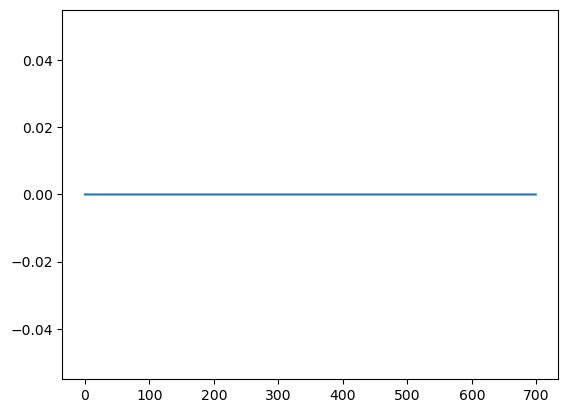

In [33]:
import matplotlib.pyplot as plt
plt.plot(episodes, scores)